In [667]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression as sklearnLogisticRegression
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import statistics

In [466]:
plt.rc('figure', figsize=(12, 6))

In [467]:
def ternary_search_min(f, left, right, eps=1e-5): 
    while right - left > eps:
        a = (left * 2 + right) / 3
        b = (left + right * 2) / 3
        if f(a) < f(b):
            right = b
        else:
            left = a
    return (left + right) / 2

Calculating the gradient:

$$ \alpha=\sigma\left(X \theta \right) $$

$$
\begin{array}{l}
\mathcal{L}(\theta)=-\log p(D \mid \theta)=-\sum_{i=1}^{n} y_{i} \log \alpha_{i}+\left(1-y_{i}\right) \log \left(1-\alpha_{i}\right) \\
\frac{\partial \mathcal{L}}{\partial \theta_{j}}=-\sum_{i=1}^{n} y_{i} x_{i j}\left(1-\alpha_{i}\right)-\left(1-y_{j}\right) x_{i j} \alpha_{i} = \sum_{i=1}^{n} \left(\alpha_i-y_{i}\right) x_{i j}
\end{array} \\
\nabla_{\theta} \mathcal{L}=X^{\top}(\alpha-y)
$$

Calculating the hessian:

$$ \frac{\partial^{2}}{\partial \theta_j \partial \theta_k} \mathcal{L} 
= \sum_{i} x_{i j}\left(\frac{\partial}{\partial \theta_{k}} \alpha_{i}\right)
= \sum_{i=1}^{n} x_{i j} x_{i k} \alpha_{i}\left(1-\alpha_{i}\right)=z_{j}^{\top} H z_{k} \\
z_{j}=\left(x_{1 j}, \ldots, x_{n} j\right)^{\top} \\
H=\left(\begin{array}{ccc}
\alpha_{1}\left(1-\alpha_{1}\right) & & 0 \\
 & \ddots & \\
0 & & \alpha_{n}\left(1-\alpha_{n}\right)
\end{array}\right) \\
\nabla^2_{\theta} \mathcal{L}=X^{\top}HX
$$

In [673]:
class LogRegression:
    def __init__(self, tolerance=1e-7):
        self.max_iterations = 10 ** 5  
        self.num_iterations = 0             
        self.stop = False                   
        self.cost_history = []
        self.tolerance = tolerance                
        self.params = None
        self.mode = None
        
    def clear(self):
        self.max_iterations = 10 ** 5     
        self.num_iterations = 0           
        self.stop = False                
        self.cost_history = []
        self.params = None
        
    def fit(self, X, y, 
            mode='gradient_descent', 
            max_iterations=10 ** 5, 
            learning_rate=0.01,
            start_params=None):
        
        self.clear()
        self.max_iterations = max_iterations
        self.params = np.zeros((X.shape[1], 1)) if start_params is None else start_params
        self.mode = mode
        
        y = y.reshape((-1, 1))
        if mode == 'gradient_descent':
            self._gradient_descent(X, y, learning_rate)
        elif mode == 'newton':
            self._newton(X, y)
        elif mode == 'steepest':
            self._steepest_gradient_descent(X, y)
        else:
            raise Exception('no such method')
            
    def predict(self, X):
        return np.round(self.sigmoid(X @ self.params))
    
    def plot_progress(self):
        plt.plot(lr.cost_history)
        plt.title("Зависимость значения функции потерь от количества итериций\nМетод {}".
                  format(self.mode), fontsize=15)
        plt.ylabel('loss', fontsize=15)
        plt.xlabel('Номер итерации', fontsize=15)
        plt.show()
            
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def compute_cost(self, X, y, params=None):
        if params is None:
            params = self.params
        m = len(y)
        h = self.sigmoid(X @ params)
        epsilon = 1e-5
        cost = (-y.T @ np.log(h + epsilon) - (1 - y).T @ np.log(1 - h + epsilon))
        return cost.ravel()[0]
            
    def _gradient_descent(self, X, y, learning_rate):
        m = len(y)
        self.cost_history.append(self.compute_cost(X, y))
        while not self.stop:
            h = self.sigmoid(X @ self.params)
            self.params -= learning_rate * (X.T @ (h - y))
            self.cost_history.append(self.compute_cost(X, y))
            self.num_iterations += 1
            self._check_stop()
            
    def _newton(self, X, y):
        m = len(y)
        self.cost_history.append(self.compute_cost(X, y))
        while not self.stop:
            h = self.sigmoid(X @ self.params)
            W = np.diag((h * (1 - h)).flat)
            hessian = X.T @ W @ X;
            gradient = X.T @ (y - h);

            try:
                step = np.dot(np.linalg.inv(hessian), gradient)
            except np.linalg.LinAlgError:
                self.stop = True
                step = 0
                print('cannot invert hessian')
            
            self.params += step
            self.cost_history.append(self.compute_cost(X, y))
            self.num_iterations += 1
            self._check_stop()
    
    def _steepest_gradient_descent(self, X, y):
        m = len(y)
        self.cost_history.append(self.compute_cost(X, y))
        while not self.stop:
            h = self.sigmoid(X @ self.params)
            gradient = X.T @ (h - y)
            shift = ternary_search_min(
                lambda shift: self.compute_cost(X, y, self.params - shift * gradient), 
                0, 100)
            self.params -= shift * gradient
            self.cost_history.append(self.compute_cost(X, y))
            self.num_iterations += 1
            self._check_stop()
    
    def _check_stop(self):
        if abs(self.cost_history[-1] - self.cost_history[-2]) < self.tolerance or self.num_iterations > self.max_iterations:
            self.stop = True

In [469]:
def plot_2d(X, y, params=None, start_params=None):
    sns.set_style('white')
    sns.scatterplot(X[:, 1], X[:, 2], hue=y.reshape(-1))
    for p, label in zip([params, start_params], ['optimal', 'start']):
        if not p is None:
            ax = plt.gca()
            ax.autoscale(False)
            x_vals = np.array(ax.get_xlim())
            y_vals = p[0] / p[2] - x_vals * p[1] / p[2]
            plt.plot(x_vals, y_vals, label=label)
    plt.legend()
    plt.show()

In [470]:
def plot_3d(X, y, params=None, start_params=None):
    fig = go.Figure(data=[go.Scatter3d(x=X[:, 1], y=X[:, 2], z=X[:, 3], mode='markers', marker=dict(
        color=y.ravel(),
        opacity=0.8
    ))])
    for p, label in zip([params, start_params], ['optimal', 'start']):
        if not p is None:
            x_grid = np.linspace(np.floor(X[:, 1].min()), np.ceil(X[:, 1].max()), 2)
            y_grid = np.linspace(np.floor(X[:, 2].min()), np.ceil(X[:, 2].max()), 2)
            x_grid,y_grid = np.meshgrid(x_grid,y_grid)
            z_grid = p[0]/p[3] - x_grid * p[1]/p[3] - y_grid * p[2]/p[3]
            fig.add_trace(go.Surface(x=x_grid, y=y_grid, z=z_grid, name=label))
    fig.show()

In [471]:
def calc_score(pred, y):
    print("Recall: ", recall_score(pred, y))
    print("Precision: ", precision_score(pred, y))    
    print("F1-score: ", f1_score(pred, y))

## Разделимые данные

### Двумерный случай

In [634]:
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, random_state=11)
y = y.reshape((-1, 1))
X = np.hstack((-np.ones((len(y), 1)), X))

Запустим самописную модель

In [635]:
lr = LogRegression()

In [ ]:
lr.fit(X, y, mode='gradient_descent')
lr.plot_progress()

In [493]:
eps_grid = np.linspace(0, 17, 10)
num_steps = []
for eps in tqdm(eps_grid):
    lr_eps = LogRegression(tolerance=1/np.exp(eps))
    lr_eps.fit(X, y, mode='gradient_descent')
    num_steps.append(lr_eps.num_iterations)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.01s/it]


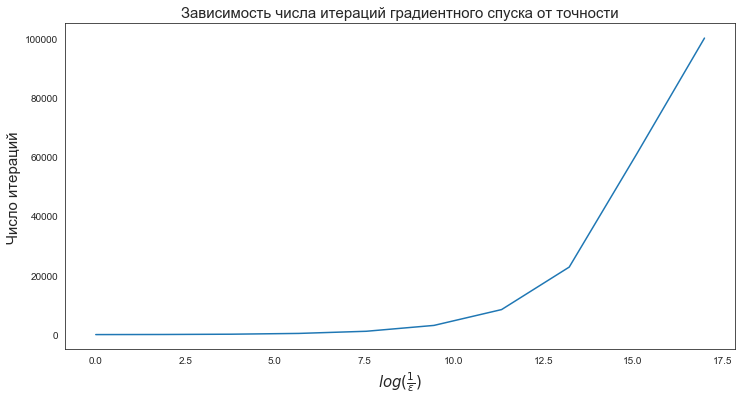

In [494]:
plt.plot(eps_grid, num_steps)
plt.xlabel('$log(\\frac{1}{\\epsilon})$', fontsize=15)
plt.ylabel('Число итераций', fontsize=15)
plt.title('Зависимость числа итераций градиентного спуска от точности', fontsize=15)
plt.show()

In [523]:
def cross_val_scores(model, X, y):
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    scores = []
    for train_index, test_index in tqdm(cv.split(X)):
        model.fit(X[train_index], y[train_index], mode='newton')
        pred = model.predict(X[test_index])
        scores.append(f1_score(pred, y[test_index]))
    return scores

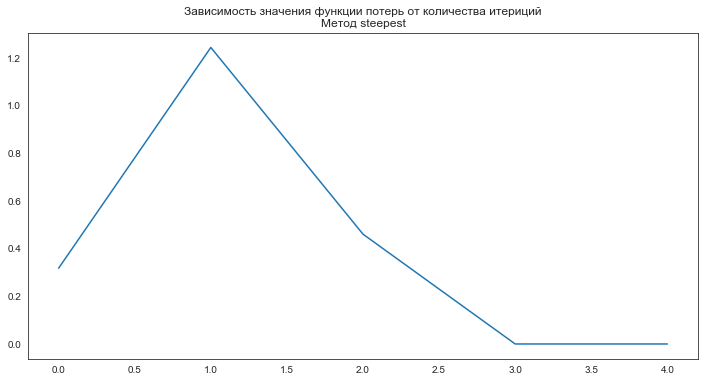

In [463]:
lr.fit(X, y, mode='steepest')
lr.plot_progress()

In [453]:
pred = lr.predict(X)
calc_score(pred, y)

Recall:  1.0
Precision:  1.0
F1-score:  1.0


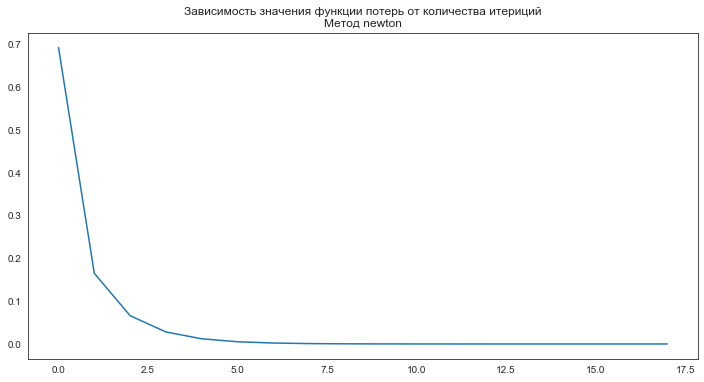

In [408]:
lr.fit(X, y, mode='newton')
lr.plot_progress()

In [641]:
eps_grid = np.linspace(0, 35, 15)
num_steps = []
for eps in tqdm(eps_grid):
    lr_eps = LogRegression(tolerance=1/np.exp(eps))
    lr_eps.fit(X, y, mode='newton')
    num_steps.append(lr_eps.num_iterations)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 20.39it/s]


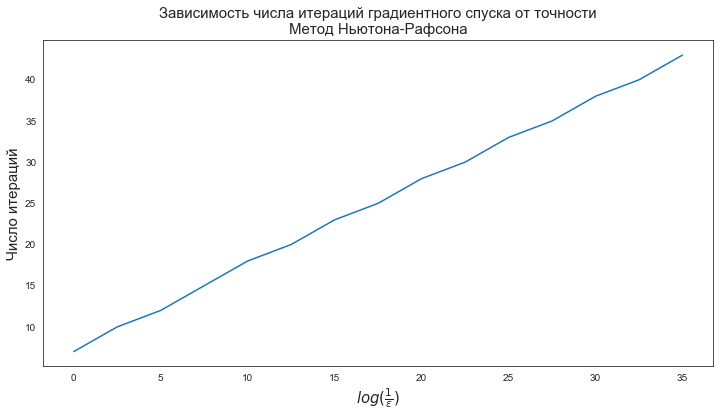

In [642]:
plt.plot(eps_grid, num_steps)
plt.xlabel('$log(\\frac{1}{\\epsilon})$', fontsize=15)
plt.ylabel('Число итераций', fontsize=15)
plt.title('Зависимость числа итераций градиентного спуска от точности\nМетод Ньютона-Рафсона', fontsize=15)
plt.show()

In [409]:
pred = lr.predict(X)
calc_score(pred, y)

Recall:  1.0
Precision:  1.0
F1-score:  1.0


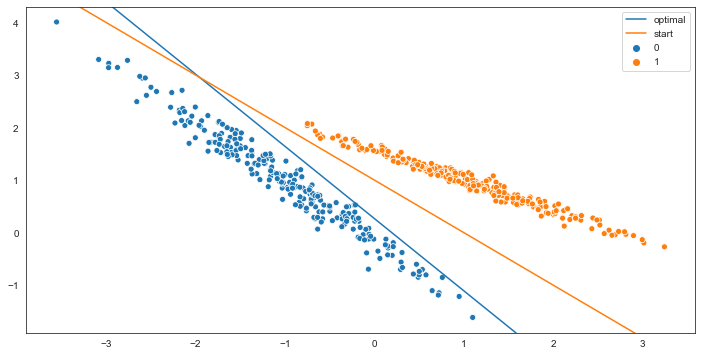

In [454]:
plot_2d(X, y, lr.params, np.ones((X.shape[1], 1)))

Проверим с помощью модели из sklearn

C:\Users\sunru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\sunru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Recall:  1.0
Precision:  1.0
F1-score:  1.0
None


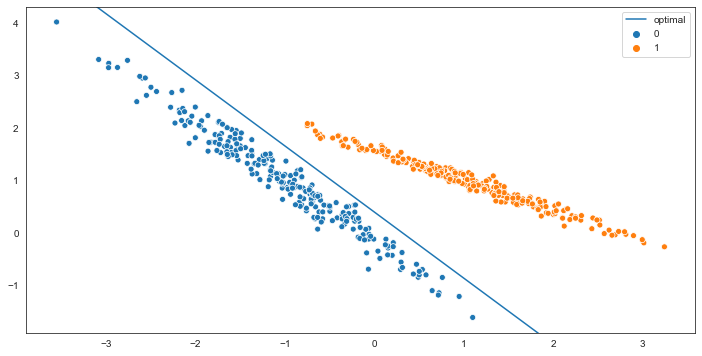

In [411]:
clf = sklearnLogisticRegression(random_state=0).fit(X, y)
pred = clf.predict(X)

print(calc_score(pred, y))

plot_2d(X, y,  clf.coef_[0])

### Трехмерный случай

In [455]:
X, y = make_classification(n_samples=100, n_features=3, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1, random_state=0)
X = np.hstack((-np.ones((len(y), 1)), X))
plot_3d(X, y)

In [413]:
start_params_3d = np.array([10., 1, 0.01, 0]).reshape((-1, 1))

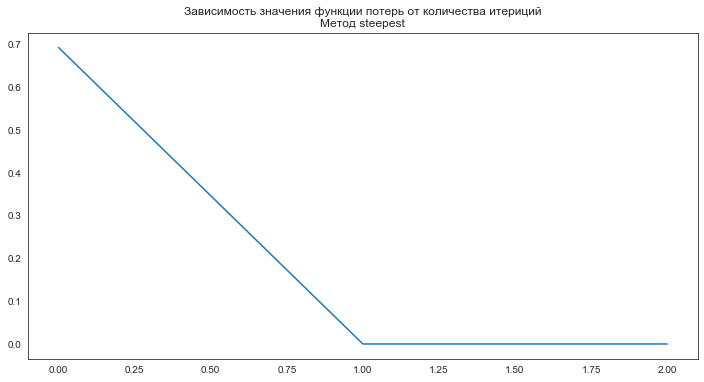

In [456]:
lr.fit(X, y, mode='steepest')
lr.plot_progress()

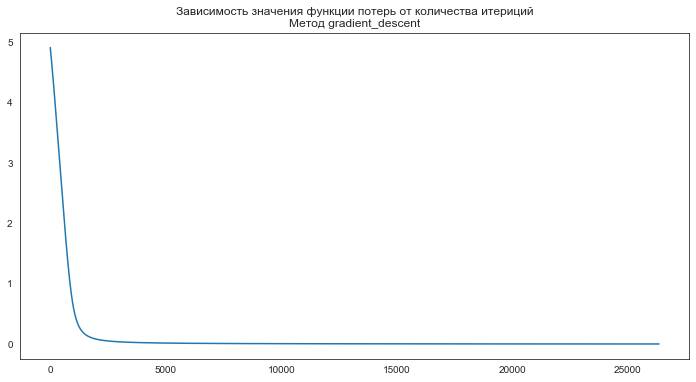

In [414]:
lr.fit(X, y, mode='gradient_descent', start_params=start_params_3d)
lr.plot_progress()

In [415]:
pred = lr.predict(X)
calc_score(pred, y)

Recall:  1.0
Precision:  1.0
F1-score:  1.0


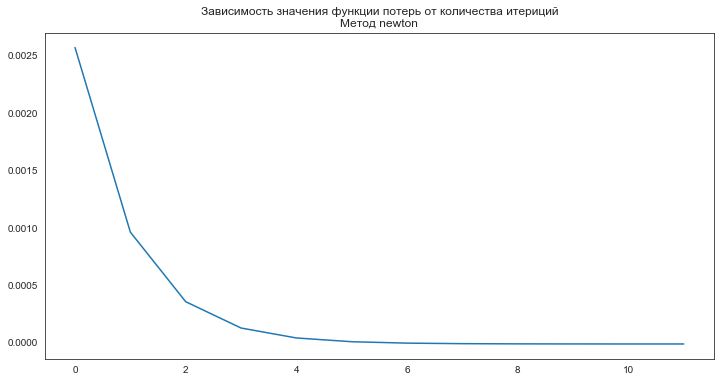

In [416]:
lr.fit(X, y, mode='newton', start_params=start_params_3d)
lr.plot_progress()

In [417]:
 lr.params.ravel(), start_params_3d

(array([ 1.29993209, -1.3106809 ,  0.10945851, 21.95000252]),
 array([[ 1.29993209],
        [-1.3106809 ],
        [ 0.10945851],
        [21.95000252]]))

In [418]:
clf.coef_[0], start_params_3d

(array([1.4047175 , 4.51949019, 3.59225237]), array([[ 1.29993209],
        [-1.3106809 ],
        [ 0.10945851],
        [21.95000252]]))

In [457]:
plot_3d(X, y, lr.params, start_params_3d)

Сравним с классификатором из sklearn

In [420]:
clf = sklearnLogisticRegression(random_state=0).fit(X, y)
pred = clf.predict(X)

print(calc_score(pred, y))

plot_3d(X, y, clf.coef_[0], start_params_3d)

C:\Users\sunru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Recall:  1.0
Precision:  1.0
F1-score:  1.0
None


## Неразделимые данные

### Двумерный случай

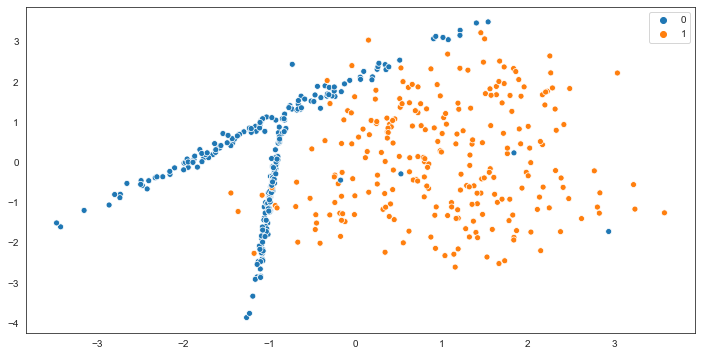

In [458]:
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=2, random_state=27)
y = y.reshape((-1, 1))
X = np.hstack((-np.ones((len(y), 1)), X))

plot_2d(X, y)

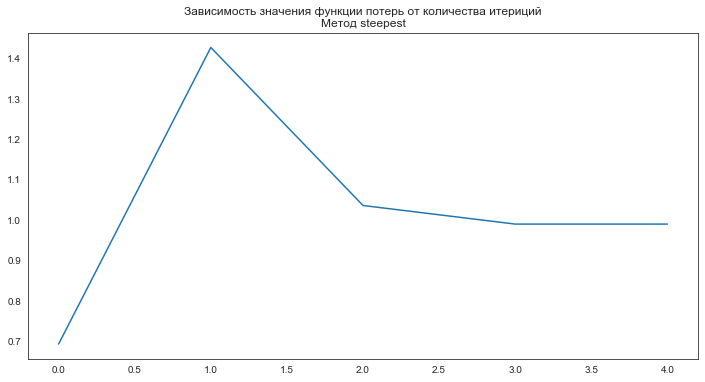

Recall:  0.9358974358974359
Precision:  0.8866396761133604
F1-score:  0.9106029106029107
None


In [459]:
lr.fit(X, y, mode='steepest')
lr.plot_progress()
pred = lr.predict(X)
print(calc_score(pred, y))

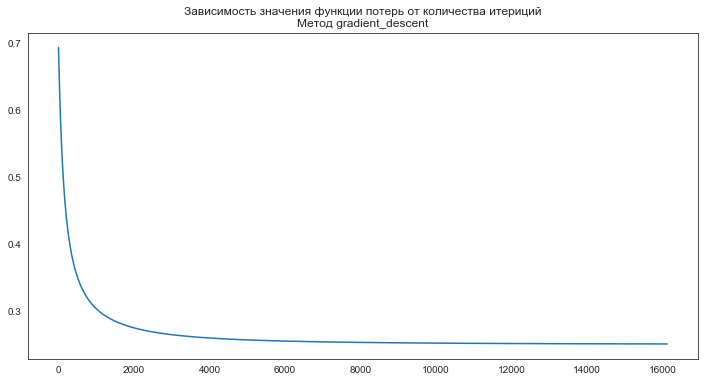

Recall:  0.9453781512605042
Precision:  0.9109311740890689
F1-score:  0.9278350515463918
None


In [461]:
lr.fit(X, y, mode='gradient_descent')
lr.plot_progress()
pred = lr.predict(X)
print(calc_score(pred, y))

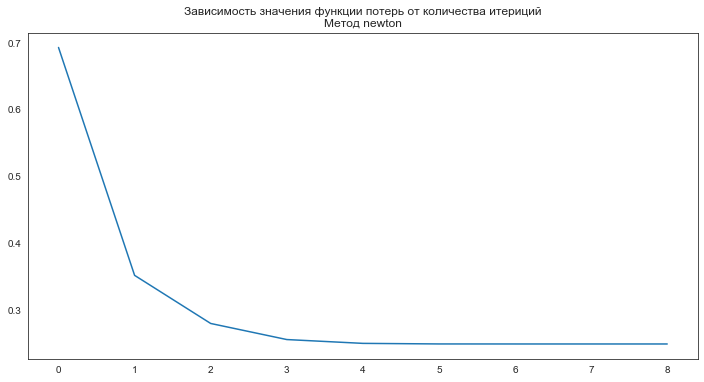

Recall:  0.9453781512605042
Precision:  0.9109311740890689
F1-score:  0.9278350515463918
None


In [423]:
lr.fit(X, y, mode='newton')
lr.plot_progress()
pred = lr.predict(X)
print(calc_score(pred, y))

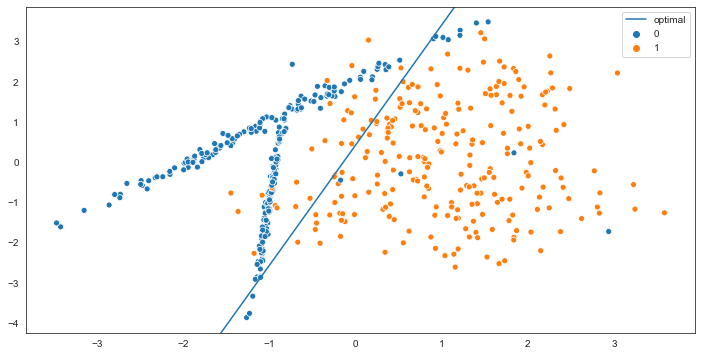

In [460]:
plot_2d(X, y, lr.params)

Сравним с классификатором из sklearn

C:\Users\sunru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\sunru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Recall:  0.9451476793248945
Precision:  0.9068825910931174
F1-score:  0.9256198347107438
None


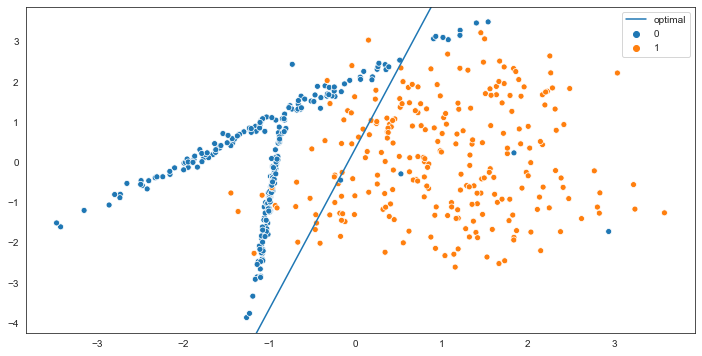

In [425]:
clf = sklearnLogisticRegression(random_state=0).fit(X, y)
pred = clf.predict(X)

print(calc_score(pred, y))

plot_2d(X, y,  clf.coef_[0])

### Трехмерный случай

In [426]:
X, y = make_classification(n_samples=500, n_features=3, n_redundant=0, n_informative=3,
                             n_clusters_per_class=3, random_state=27)
X = np.hstack((-np.ones((len(y), 1)), X))
plot_3d(X, y)

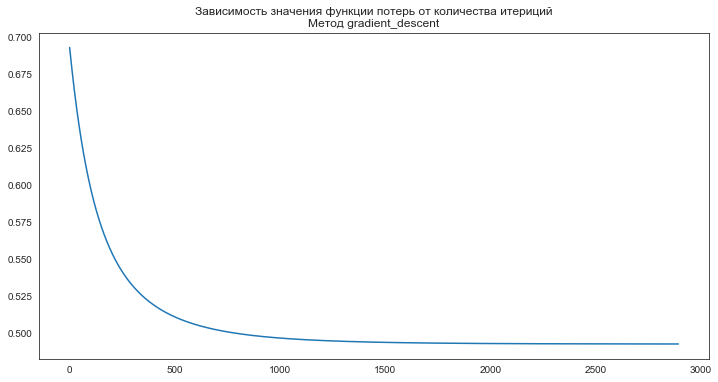

Recall:  0.768
Precision:  0.768
F1-score:  0.768
None


In [427]:
lr.fit(X, y, mode='gradient_descent')
lr.plot_progress()
pred = lr.predict(X)
print(calc_score(pred, y))

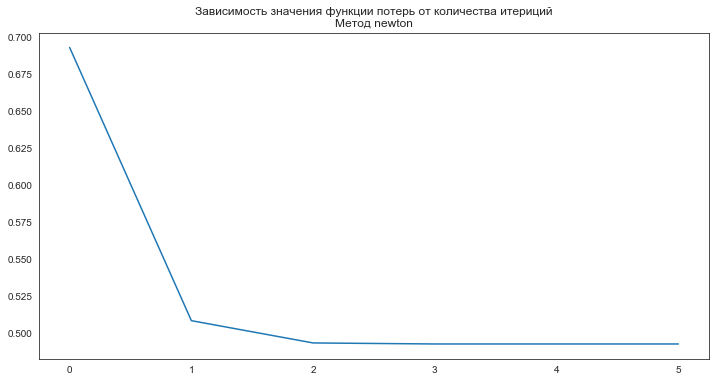

Recall:  0.7701612903225806
Precision:  0.764
F1-score:  0.7670682730923695
None


In [428]:
lr.fit(X, y, mode='newton')
lr.plot_progress()
pred = lr.predict(X)
print(calc_score(pred, y))

In [429]:
plot_3d(X, y, lr.params)

Сравним с классификатором из sklearn

In [430]:
clf = sklearnLogisticRegression(random_state=0).fit(X, y)
pred = clf.predict(X)

print(calc_score(pred, y))

plot_3d(X, y, clf.coef_[0])

C:\Users\sunru\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Recall:  0.7701612903225806
Precision:  0.764
F1-score:  0.7670682730923695
None


### Тестирование с помощью ЛДА

In [578]:
import scipy.stats as sps

#### Разделимые данные

In [663]:
sigma = np.array([[1, 0], [0, 1]])
mu_0 = np.array([0, 0])
mu_1 = np.array([10, 10])

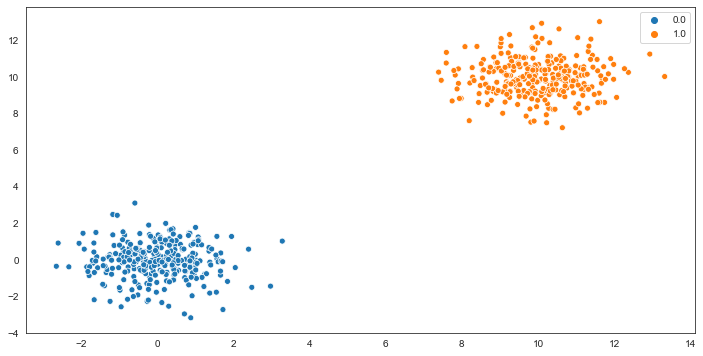

In [664]:
sample_0 = sps.multivariate_normal(mu_0, sigma).rvs(size=300)
sample_1 = sps.multivariate_normal(mu_1, sigma).rvs(size=300)

X = np.concatenate((sample_0, sample_1))
y = np.concatenate((np.zeros(shape=len(sample_0)), np.ones(shape=len(sample_0))))
X = np.hstack((-np.ones((len(y), 1)), X))

plot_2d(X, y)

$${\vec {w}}=\Sigma ^{-1}({\vec {\mu }}_{1}-{\vec {\mu }}_{0}) \\
c={\vec {w}}\cdot {\frac {1}{2}}({\vec {\mu }}_{1}+{\vec {\mu }}_{0})$$

In [665]:
w = np.linalg.inv(sigma) @ (mu_1 - mu_0)

c = w @ (mu_0 + mu_1) / 2

$$ {\vec {w}}\cdot {\vec {x}}>c $$

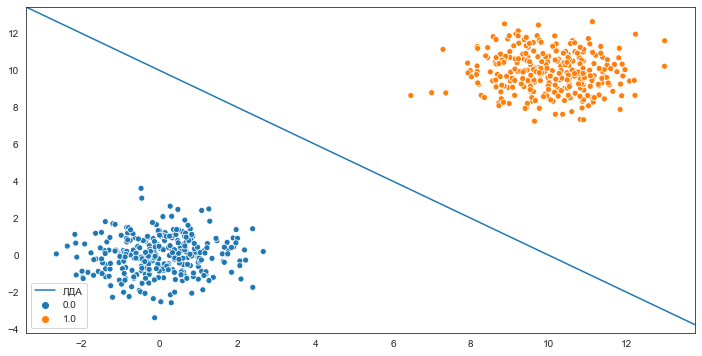

In [623]:
sns.scatterplot(X[:, 1], X[:, 2], hue=y.reshape(-1))
ax = plt.gca()
ax.autoscale(False)
x_vals = np.array(ax.get_xlim())
y_vals = c / w[1] - x_vals * w[0] / w[1]
plt.plot(x_vals, y_vals, label='ЛДА')
plt.legend()
plt.show()

In [624]:
lr.fit(X, y)

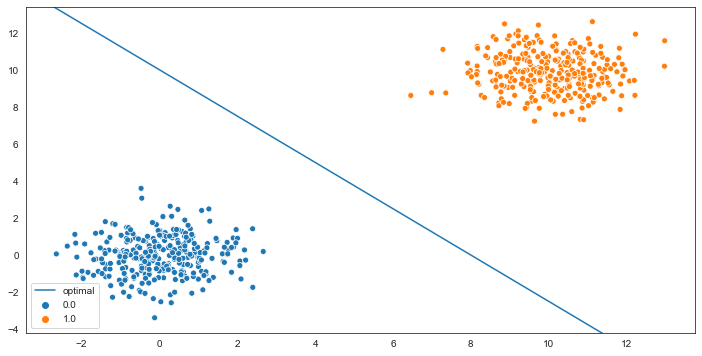

In [625]:
plot_2d(X, y, lr.params)

#### Неразделимые данные

In [628]:
sigma = np.array([[1, 0], [0, 1]])
mu_0 = np.array([0, 0])
mu_1 = np.array([0, 3])

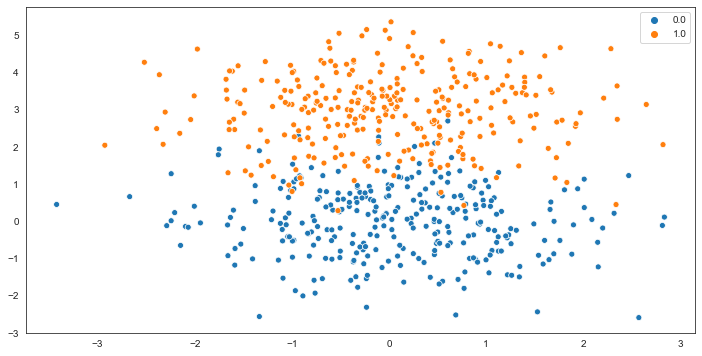

In [629]:
sample_0 = sps.multivariate_normal(mu_0, sigma).rvs(size=300)
sample_1 = sps.multivariate_normal(mu_1, sigma).rvs(size=300)

X = np.concatenate((sample_0, sample_1))
y = np.concatenate((np.zeros(shape=len(sample_0)), np.ones(shape=len(sample_0))))
X = np.hstack((-np.ones((len(y), 1)), X))

plot_2d(X, y)

In [630]:
w = np.linalg.inv(sigma) @ (mu_1 - mu_0)

c = w @ (mu_0 + mu_1) / 2

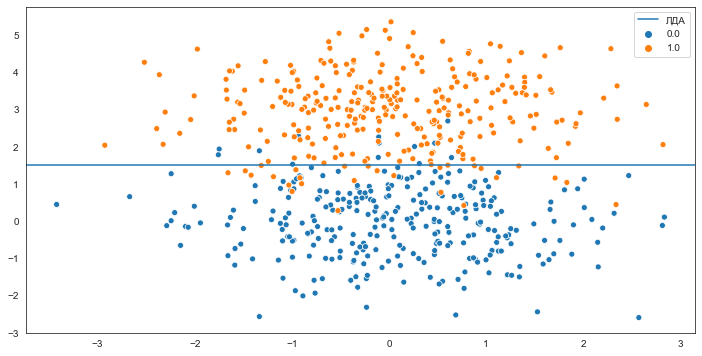

In [631]:
sns.scatterplot(X[:, 1], X[:, 2], hue=y.reshape(-1))
ax = plt.gca()
ax.autoscale(False)
x_vals = np.array(ax.get_xlim())
y_vals = c / w[1] - x_vals * w[0] / w[1]
plt.plot(x_vals, y_vals, label='ЛДА')
plt.legend()
plt.show()

In [632]:
lr.fit(X, y)

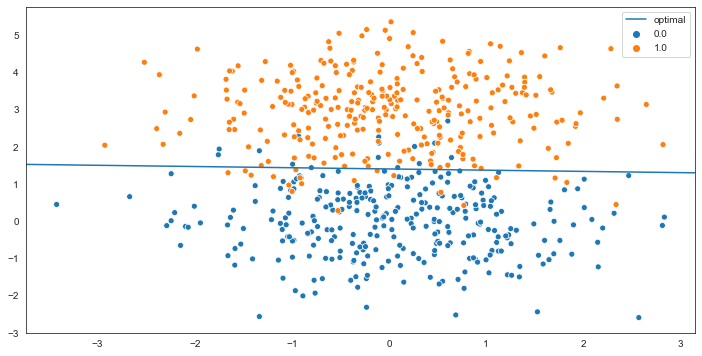

In [633]:
plot_2d(X, y, lr.params)

### Применение модели

Задача с Kaggle https://www.kaggle.com/ronitf/heart-disease-uci

In [563]:
data = shuffle(pd.read_csv('heart.csv')).reset_index(drop=True)

In [564]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,47,1,2,138,257,0,0,156,0,0.0,2,0,2,1
1,60,0,2,102,318,0,1,160,0,0.0,2,1,2,1
2,61,0,0,145,307,0,0,146,1,1.0,1,0,3,0
3,43,0,0,132,341,1,0,136,1,3.0,1,0,3,0
4,58,1,0,150,270,0,0,111,1,0.8,2,0,3,0


In [532]:
from sklearn.utils import shuffle

In [649]:
X = data.drop(columns=['target'])
y = data.target

In [571]:
X_train, X_test = X[:250], X[250:]
y_train, y_test = y[:250], y[250:]

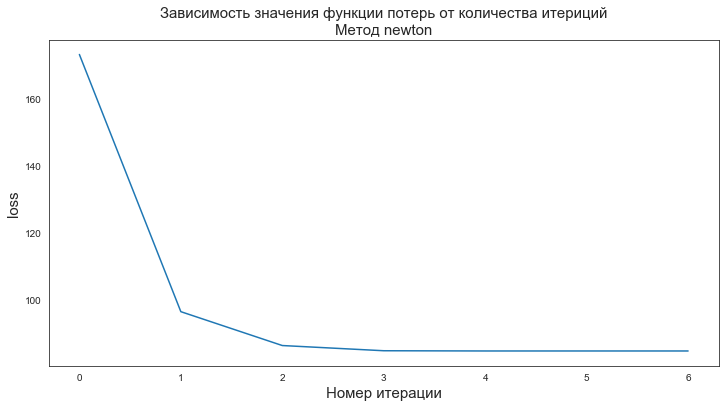

In [576]:
lr.fit(X_train.values, y_train.values, mode='newton')
lr.plot_progress()

In [573]:
pred = lr.predict(X_test.values)

In [574]:
calc_score(pred, y_test.values)

Recall:  0.6923076923076923
Precision:  0.9642857142857143
F1-score:  0.8059701492537313


In [651]:
scores = np.array(cross_val_scores(lr, X.values, y.values))

5it [00:00, 146.66it/s]


In [654]:
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.87 (+/- 0.03)


Видим, что модель показывает хороший результат на реальных данных